In [1]:
import numpy as np
from skimage.feature import corner_harris, peak_local_max
import json
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import skimage as sk
import scipy as sci
from scipy.interpolate import RegularGridInterpolator
import skimage.io as io
from scipy import ndimage
from matplotlib.path import Path
from PIL import Image, ImageDraw
from sklearn.neighbors import NearestNeighbors
import cv2

Code to find corresponding points

In [2]:
def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method="eps", sigma=1)
    coords = peak_local_max(h, min_distance=1)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (
        (coords[:, 0] > edge)
        & (coords[:, 0] < im.shape[0] - edge)
        & (coords[:, 1] > edge)
        & (coords[:, 1] < im.shape[1] - edge)
    )
    coords = coords[mask].T
    return h, coords

def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """

    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert (dimx == dimc, "Data dimension does not match dimension of centers")

    return (
        (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T
        + np.ones((ndata, 1)) * np.sum((c**2).T, axis=0)
        - 2 * np.inner(x, c)
    )

def anms(coords, threshold, h):
    r = np.empty((coords.shape[1]))
    for i in range(0, coords.shape[1]):
        currH = h[coords[0, i], coords[1, i]]

        # start = timer()
        filteredY = coords[0][currH < threshold * h[coords[0], coords[1]]]
        filteredX = coords[1][currH < threshold * h[coords[0], coords[1]]]
        filteredCoords = np.array([filteredY, filteredX])

        filteredCoords[0] = np.square((coords[0, i] - filteredCoords[0]))
        filteredCoords[1] = np.square((coords[1, i] - filteredCoords[1]))

        sqDistances = filteredCoords[0] + filteredCoords[1]

        r[i] = float("inf") if len(sqDistances) == 0 else np.min(sqDistances)
        # r[i] = 0 if len(sqDistances) == 0 else np.min(sqDistances)
        # end = timer()
        # print(f"seq: {end-start}")
        # print(i)
        # print()

    return np.argsort(-r)

def findKeypoints(im, anmsThresh, numPoints):
    h, coords = get_harris_corners(im)
    # print(h.shape)
    # print(coords.shape)
    r = anms(coords[:], anmsThresh, h)
    topr = r[:numPoints]
    topCoords = coords[:, topr]
    topCoords = topCoords.swapaxes(0, 1)
    return topCoords

def featureDescriptors(im, coords, descriptorWidth, downSampleRatio, flatten=False):
    # Dont have to worry about edge coords bc of the harrison corner function

    descriptor = np.empty((coords.shape[0], descriptorWidth, descriptorWidth))
    reducedImg = sk.transform.downscale_local_mean(im, downSampleRatio)
    reducedCoords = np.floor_divide(coords, downSampleRatio)
    # print(reducedImg.shape)

    # print(reducedCoords)
    for i in range(coords.shape[0]):
        y, x = reducedCoords[i, 0], reducedCoords[i, 1]
        # print(f"[{y - (descriptorWidth // 2)} : {y + (descriptorWidth - (descriptorWidth // 2))},{x - (descriptorWidth // 2)} : {x + (descriptorWidth - (descriptorWidth // 2))}]")
        # print(y - (descriptorWidth // 2))
        # print(y + (descriptorWidth - (descriptorWidth // 2)))
        # print(x - (descriptorWidth // 2))
        # print(x + (descriptorWidth - (descriptorWidth // 2)))
        descriptor[i] = reducedImg[
            y - (descriptorWidth // 2) : y + (descriptorWidth - (descriptorWidth // 2)),
            x - (descriptorWidth // 2) : x + (descriptorWidth - (descriptorWidth // 2)),
        ]

        descriptor[i] = (descriptor[i] - np.mean(descriptor[i])) / np.std(descriptor[i])

    if flatten:
        descriptor = np.reshape(
            descriptor, (descriptor.shape[0], descriptor.shape[1] ** 2)
        )
    return descriptor

<>:47: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:47: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_26417/1674258093.py:47: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (dimx == dimc, "Data dimension does not match dimension of centers")


TODO: Code to find pixle points on image into 3D points in space

Code for calculating transform from points

In [3]:
def rigid_transform_3D(A, B):
    # Input: expects 3xN matrix of points
    # Returns R,t
    # R = 3x3 rotation matrix
    # t = 3x1 column vector
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    # if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2, :] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

def calcH(im1Pt, im2Pt):
    """
    Finds the H transformation matrix using least squares for im1 and im2 points.

    Args:
        im1Pt (Nx3 np.array): im1 correspondances
        im2Pt (Nx3 np.array): im2 correspondances

    Returns:
        h (3x3 np.array): Linear solution of the transformation matrix
    """
    R, t = rigid_transform_3D(im1Pt.T, im2Pt.T)

    h = np.identity(4)

    h[0:2, 0:2] = R
    h[0:2, 3] = t

    return h


def transformPoints(points, H):
    """
    Divides out W term in transformed points

    Args:
        points (Nx3 np.array): x,y,z coordinates of points
        H (4x4 np.array): Transformation Matrix

    Returns:
        result (Nx3 np.array): Original points transformed by H
    """
    ones = np.ones((points.shape[0], 1))
    homogPoints = np.append(points, ones, 1)
    transformedPoints = np.array([H @ p for p in homogPoints])
    return transformedPoints[:, 0:3]

def ransac(im1Coords, im2Coords, iterations, percentage, inlierTolerance=0.1):
    # Stops when either iterations are met, or if a percentage of the coords are in the inlier set
    largestInlier = []
    bestH = None
    rng = np.random.default_rng(12345)
    for i in range(iterations):
        rints = rng.integers(low=0, high=len(im1Coords) - 1, size=4)
        # print(rints)
        # print(im1Coords[rints], im2Coords[rints])
        H = calcH(im1Coords[rints], im2Coords[rints])
        guessCoords = transformPoints(im1Coords, H)
        distances = np.linalg.norm(guessCoords - im2Coords, axis=1)
        # print(distances.shape)
        # print(distances)
        inlier = np.argwhere(distances < inlierTolerance)
        if inlier.shape[0] > len(largestInlier):
            largestInlier = list(inlier[:, 0])
            print(
                f"{i}: {len(largestInlier)}, ({len(largestInlier)/im1Coords.shape[0]*100}%)"
            )
            if len(largestInlier) / im1Coords.shape[0] >= percentage:
                im1RANSACPts = im1Coords[largestInlier, :]
                im2RANSACPts = im2Coords[largestInlier, :]
                bestH = calcH(im1RANSACPts, im2RANSACPts)
                return largestInlier, bestH

    im1RANSACPts = im1Coords[largestInlier, :]
    im2RANSACPts = im2Coords[largestInlier, :]
    bestH = calcH(im1RANSACPts, im2RANSACPts)
    return largestInlier, bestH

In [4]:
im1 = ndimage.rotate(io.imread("../../Assets/dot-1_Color.png"), -90)
im2 = ndimage.rotate(io.imread("../../Assets/dot-1_Color.png"), -90)

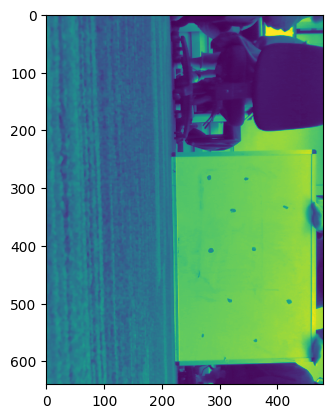

In [5]:
im1Grey = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
im2Grey = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)
plt.imshow(im1Grey)

In [6]:
h, pointsim1 = get_harris_corners(im1Grey, edge_discard=20)
h, pointsim2 = get_harris_corners(im2Grey)

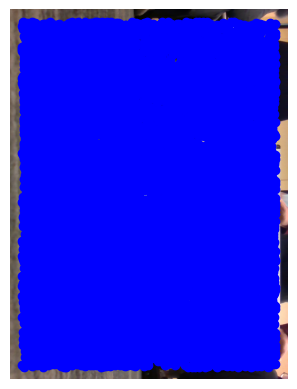

In [7]:
plt.imshow(im1)
plt.axis("off")

plt.plot(pointsim1[1, :], pointsim1[0, :], "bo")
plt.savefig("../../Assets/resultsPt2/harrisCorners.jpg", bbox_inches="tight", dpi=1000)

In [8]:
im1CoordGrey = findKeypoints(im1Grey, 0.9, 200)
im2CoordGrey = findKeypoints(im2Grey, 0.9, 200)

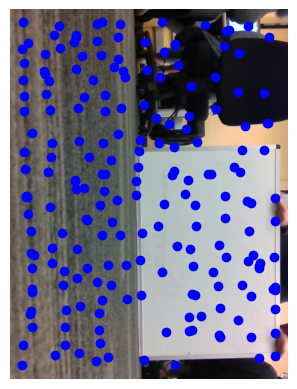

In [9]:
plt.imshow(im1)
plt.axis("off")

plt.plot(im1CoordGrey[:, 1], im1CoordGrey[:, 0], "bo")
plt.savefig("../../Assets/resultsPt2/im1ANMS80.jpg", bbox_inches="tight", dpi=1000)

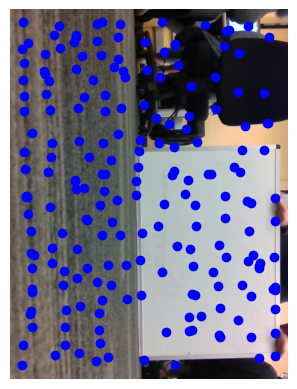

In [10]:
plt.imshow(im2)
plt.axis("off")

plt.plot(im2CoordGrey[:, 1], im2CoordGrey[:, 0], "bo")

In [11]:
descriptorim1Color = featureDescriptors(im1Grey, im1CoordGrey, 8, 5, True)
descriptorim2Color = featureDescriptors(im2Grey, im2CoordGrey, 8, 5, True)
nbrs = NearestNeighbors(n_neighbors=2, algorithm="ball_tree").fit(descriptorim2Color)
distances, indices = nbrs.kneighbors(descriptorim1Color)
selectedPoints = np.argwhere((distances[:, 0] / distances[:, 1]) < 0.75)
print(selectedPoints.T)

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  25  27  28  29  30  31  32  33  34  35  36  37
   38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
   56  57  58  59  61  62  63  65  66  67  68  70  71  72  74  75  77  78
   79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
   99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
  117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
  135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
  153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
  171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
  189 190 191 192 193 194 195 196 197 198 199]]


/tmp/ipykernel_26417/545578197.py:5: RuntimeWarning: invalid value encountered in true_divide
  selectedPoints = np.argwhere((distances[:, 0] / distances[:, 1]) < 0.75)


In [12]:
keyPointsIm1 = im1CoordGrey[selectedPoints.T][0]
keyPointsIm2 = im2CoordGrey[indices[selectedPoints.T, 0]][0]

print(keyPointsIm1.shape, keyPointsIm2.shape)

shiftedKeypointsIm2 = keyPointsIm2.copy()
shiftedKeypointsIm2[:, 0] = shiftedKeypointsIm2[:, 0] + im1.shape[0]
combinedIm = np.vstack([im1, im2])

(191, 2) (191, 2)


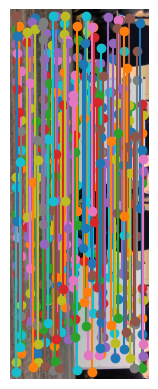

In [13]:
plt.imshow(combinedIm)
plt.axis("off")
plt.plot(
    np.vstack([keyPointsIm1[:, 1], shiftedKeypointsIm2[:, 1]]),
    np.vstack([keyPointsIm1[:, 0], shiftedKeypointsIm2[:, 0]]),
    "-o",
)
plt.savefig("../../Assets/resultsPt2/keypoints0_75Lowes.jpg", bbox_inches="tight", dpi=1000)

In [16]:
#TODO: Change pixle points to homogenous points in 3D space
from convertPixelTo3D import map2DTo3D, main, readInstantImage, loadCameraConfig
import cv2 as cv
depth_img_path = '../../Assets/dot-1_Depth.raw'
rgb_img_path = '../../Assets/dot-1_Color.png'
rgb_img, depth_img = readInstantImage(rgb_img_path, depth_img_path, display=False)
intrinsic_matrix = loadCameraConfig(depth_img)

homogenous_point_img_1, zero_coord_number_1 = map2DTo3D(rgb_img, depth_img, keyPointsIm1, intrinsic_matrix)
homogenous_point_img_2, zero_coord_number_2 = map2DTo3D(rgb_img, depth_img, keyPointsIm2, intrinsic_matrix)
print(f'Valid matched points of img_1 are {len(homogenous_point_img_1)}, invalid ones are {zero_coord_number_1}')
print(f'Valid matched points of img_2 are {len(homogenous_point_img_2)}, invalid ones are {zero_coord_number_2}')
print(homogenous_point_img_1[0])

RGB image shape: (480, 640, 3)
Depth image shape: (240, 320)
Valid matched points of img_1 are 90, invalid ones are 101
Valid matched points of img_2 are 90, invalid ones are 101
[-0.3297748565673828, -0.7596534490585327, 1.4910000562667847, 1]


In [15]:
im1Pts = np.stack([keyPointsIm1[:, 1], keyPointsIm1[:, 0]], axis=1)
im2Pts = np.stack([keyPointsIm2[:, 1], keyPointsIm2[:, 0]], axis=1)
largestInlier, bestH = ransac(im1Pts, im2Pts, 1000, 0.9, 0.8)

im1RANSACPts = im1Pts[largestInlier, :]
im2RANSACPts = im2Pts[largestInlier, :]

Exception: matrix A is not 3xN, it is 2x4

In [ ]:
#Modify to show 3D points
plt.imshow(combinedIm)

plt.axis("off")
plt.plot(
    np.vstack([keyPointsIm1[largestInlier, 1], shiftedKeypointsIm2[largestInlier, 1]]),
    np.vstack([keyPointsIm1[largestInlier, 0], shiftedKeypointsIm2[largestInlier, 0]]),
    "-o",
)
plt.savefig("./resultsPt2/afterRANSAC_2Tol.jpg", bbox_inches="tight", dpi=1000)